# A complete use case

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from discopy.tensor import Tensor
from jax import numpy as np
import numpy

np.random = numpy.random
Tensor.np = np

np.random.seed(123458)  # Fix the seed

In [2]:
# Read data
def read_data(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    data, targets = [], []
    for ln in lines:
        t = int(ln[0])
        data.append(ln[1:].strip())
        targets.append(np.array([t, not(t)], dtype=np.float32))
    return data, np.array(targets)

train_data, train_targets = read_data('datasets/mc_train_data.txt')
test_data, test_targets = read_data('datasets/mc_test_data.txt')

The first few lines of the train dataset:

In [3]:
train_data[:10]

['skillful man prepares sauce',
 'skillful man bakes dinner',
 'woman cooks tasty meal',
 'man prepares meal',
 'skillful woman debugs program',
 'woman prepares tasty meal',
 'person runs program',
 'person runs useful application',
 'woman prepares sauce',
 'woman prepares dinner']

Targets are represented as 2-dimensional arrays:

In [4]:
train_targets

DeviceArray([[1., 0.],
             [1., 0.],
             [1., 0.],
             ...,
             [0., 1.],
             [1., 0.],
             [0., 1.]], dtype=float32)

## Creating and parameterising diagrams

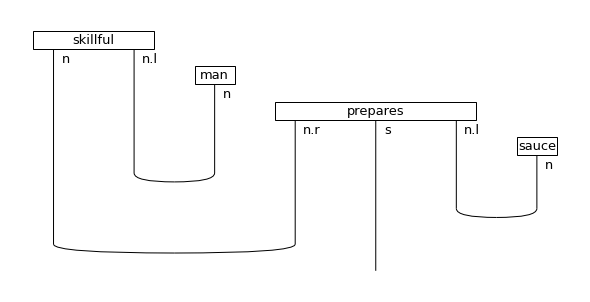

In [5]:
# Parse sentences to diagrams

from lambeq.ccg2discocat import DepCCGParser

parser = DepCCGParser()
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

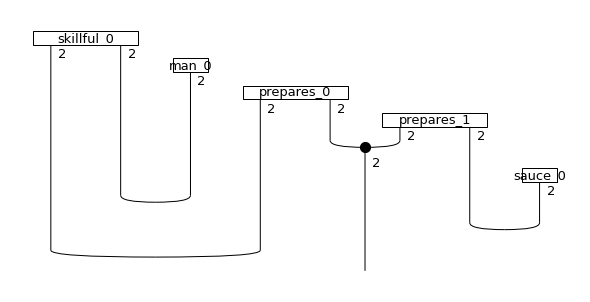

In [6]:
# Create ansatz and convert to tensor diagrams

from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType
from discopy import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

## Creating a vocabulary

We are now ready to create a vocabulary.

In [7]:
# Create vocabulary

from sympy import default_sort_key

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.35743395, 0.45764418])

## Defining a loss function

This is a binary classification task, so we will use binary cross entropy as the loss.

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

In [9]:
from jax import jit, grad

training_loss = jit(loss)
gradient = jit(grad(loss))

## Training loop

In [10]:
training_losses = []

epochs = 90

for i in range(epochs):

    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

Epoch 10 - loss 0.07233709841966629
Epoch 20 - loss 0.015333528630435467
Epoch 30 - loss 0.00786149874329567
Epoch 40 - loss 0.00515687046572566
Epoch 50 - loss 0.0037753921933472157
Epoch 60 - loss 0.0029438300989568233
Epoch 70 - loss 0.002392344642430544
Epoch 80 - loss 0.0020021884702146053
Epoch 90 - loss 0.001713048666715622


## Testing

Finally, we use the trained model on the test dataset:

In [11]:
# Testing

np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

Accuracy on test set: 0.9


## Working with quantum circuits

1. The parameterisable part of the circuit is an array of parameters, as described in Section [Circuit Symbols](training-symbols.ipynb#Circuit-symbols), instead of tensors associated to words.
2. If optimisation takes place on quantum hardware, standard automatic differentiation cannot be used. An alternative is to use a gradient-approximation technique, such as [Simultaneous Perturbation Stochastic Approximation](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation) (SPSA).

- [Quantum pipeline with JAX](../examples/quantum_pipeline_jax.ipynb)
- [Quantum pipeline with tket](../examples/quantum_pipeline_tket.ipynb)